In [1]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import TransE
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
%matplotlib inline

In [3]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

In [4]:
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]


In [5]:
print(time.asctime())

Mon May  6 17:45:49 2019


In [6]:
print(pykeen.get_version())

0.0.26-dev


Check which hyper-parameters are required by TransE:

In [7]:
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'scoring_function',
 'normalization_of_entities']

Define output directory:

In [8]:
output_directory = os.path.join(
    os.path.expanduser('~'), 
    'Desktop', 
    'pykeen_test'
)

Define hyper-parameters:

Train TransE:

In [9]:
# Load data
from pykeen.utilities.pipeline import prepare_data
triples, entity_label_to_id, relation_label_to_id, all_entities, num_entities, num_relations = prepare_data('../../tests/resources/data/rdf.nt')

In [10]:
config = dict(
    random_seed                 = 0,
    embedding_dim               = 50,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 1,
    device                      = 'gpu',
    num_entities                = num_entities,
    num_relations               = num_relations,
)

fit_config = dict(
    learning_rate               = 0.01,
    num_epochs                  = 50,  
    batch_size                  = 64
)

In [11]:
model = TransE(**config)

In [12]:
losses = model.fit(all_entities, triples, **fit_config)

INFO:pykeen.kge_models.base:****Run Model On CPU****
Training epoch: 100%|██████████| 50/50 [00:00<00:00, 19.03it/s]
INFO:pykeen.kge_models.base:Training took 1 seconds 



Access trained model:

In [13]:
model

TransE(
  (criterion): MarginRankingLoss()
  (entity_embeddings): Embedding(89, 50)
  (relation_embeddings): Embedding(24, 50)
)

Visualize loss values:

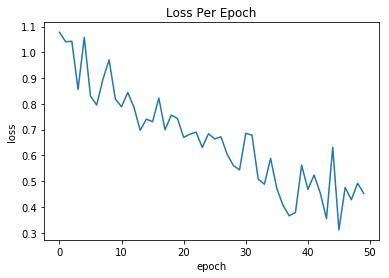

In [14]:
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

Move model to cpu

In [15]:
model._to_cpu()

Load test triples

In [16]:
test_triples, _, _, _, _, _ = prepare_data('../../tests/resources/data/rdf.nt')

Calculate results

In [17]:
from pykeen.utilities.evaluation_utils.metrics_computations import compute_metric_results

In [18]:
results = compute_metric_results(all_entities=all_entities, kg_embedding_model=model, mapped_train_triples=triples, 
                                mapped_test_triples=test_triples, device = model.device, filter_neg_triples=False)

⚽️ corrupting triples: 100%|██████████| 106/106 [00:00<00:00, 799.15it/s]
INFO:pykeen.utilities.evaluation_utils.metrics_computations:Evaluation took 0.14s seconds


In [19]:
results

MetricResults(mean_rank=14.24056603773585, hits_at_k={1: 0.0, 3: 0.2169811320754717, 5: 0.3113207547169811, 10: 0.5141509433962265})